In [37]:
#Librerias
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import PLSRegression
import statsmodels.api as sm
import matplotlib.pyplot as plt

### 1. Unificar Bases de Datos 

In [13]:
# 1. Cargar las bases de datos
themes_df = pd.read_csv('data/[per]_[all_themes]_[monthly]_[vw_cap].csv')
mkt_df = pd.read_csv('data/[per]_[mkt]_[monthly]_[vw_cap].csv')

In [14]:
# 2. Dar formato de tiempo (datetime) a las fechas para que se alineen perfectamente
themes_df['date'] = pd.to_datetime(themes_df['date'])
mkt_df['date'] = pd.to_datetime(mkt_df['date'])

In [15]:
# 3. Pivotear la tabla de "themes"
# Pasamos de formato largo a ancho (cada tema en su propia columna)
themes_pivot = themes_df.pivot(index='date', columns='name', values='ret').reset_index()

In [16]:
# 4. Limpiar la base de mercado (mkt)
# Solo necesitamos la fecha y el retorno (lo renombramos a 'mkt_ret' para no confundir)
mkt_clean = mkt_df[['date', 'ret']].rename(columns={'ret': 'mkt_ret'})

In [17]:
# 5. Cruzar (Merge) ambas bases usando la fecha
merged_df = pd.merge(mkt_clean, themes_pivot, on='date', how='inner')

In [18]:
# 6. Calcular las estadísticas descriptivas para tu informe
# Calculamos: Media, Desviación Estándar, Asimetría (Skewness) y Curtosis
stats = merged_df.drop(columns=['date']).agg(['mean', 'std', 'skew', 'kurtosis']).T
print("Estadísticas Descriptivas:")
print(stats)

Estadísticas Descriptivas:
                         mean       std      skew  kurtosis
mkt_ret              0.009604  0.066348 -0.372593  4.015210
accruals             0.001495  0.043010  0.405352  0.818392
debt_issuance        0.000176  0.029739  0.467905  3.372830
investment          -0.001495  0.027612 -0.245661  1.474707
low_leverage        -0.001305  0.028204  0.368366  1.695800
low_risk             0.001757  0.030867 -0.659627  3.618459
momentum             0.002120  0.050721 -0.285504  2.624533
profit_growth        0.003320  0.028506 -0.435621  3.104590
profitability        0.006006  0.037155  0.967637  9.530497
quality              0.004060  0.040382  0.127193  3.446077
seasonality         -0.001405  0.024208 -0.478974  3.019895
short_term_reversal  0.000695  0.048414  0.003067  4.412375
size                 0.000396  0.039573  0.211964  1.912320
value                0.006568  0.030249 -0.349448  3.216936


In [19]:
# 7. Guardar el archivo final
merged_df.to_csv('base_unificada_themes_mkt.csv', index=False)

In [28]:
df = pd.read_csv('base_unificada_themes_mkt.csv')
df['date'] = pd.to_datetime(df['date'])
# 1. ordenar por fecha para evitar sesgos al desfasar los datos
df = df.sort_values('date').reset_index(drop=True)

### 2. Crear la variable dependiente (Target)

In [ ]:
# Queremos predecir el retorno del mercado del mes SIGUIENTE (t+1) usando la información de hoy (t)
df['mkt_ret_lead1'] = df['mkt_ret'].shift(-1)

In [30]:
# Al desplazar, el último mes se queda sin 'target' (NaN), así que lo eliminamos
df_clean = df.dropna().copy()

In [31]:
# Definir las variables independientes (X) y la dependiente (y)
# Excluimos las columnas que no son características/temas
themes_cols = [col for col in df_clean.columns if col not in ['date', 'mkt_ret', 'mkt_ret_lead1']]
X = df_clean[themes_cols]
y = df_clean['mkt_ret_lead1']

# Estandarizar los temas (Z-score) antes de aplicar PCA/PLS es obligatorio en Machine Learning
X_std = (X - X.mean()) / X.std()

### 3. Modelo 1: Principal Component Analysis (PCA)

In [ ]:
# Extrae el "componente principal" que resume la mayor varianza conjunta de todos los temas
pca = PCA(n_components=1)
df_clean['PCA_Factor'] = pca.fit_transform(X_std)

### 4. Modelo 2: Partial Least Squares (PLS)

In [ ]:
# Extrae un factor que resume los temas pero buscando maximizar la covarianza con el retorno futuro (Target)
pls = PLSRegression(n_components=1)
pls.fit(X_std, y)
df_clean['PLS_Factor'] = pls.transform(X_std)

### 5. REGRESIONES PREDICTIVAS (Con Errores Robustos)

In [ ]:
print("==================================================")
print("SECCIÓN 1: Regresión Predictiva usando PCA")
print("==================================================")
X_pca = sm.add_constant(df_clean['PCA_Factor'])
# Usamos maxlags=3 para la corrección Newey-West (HAC)
model_pca = sm.OLS(y, X_pca).fit(cov_type='HAC', cov_kwds={'maxlags': 3})
print(model_pca.summary().tables[1])
print(f"R-cuadrado PCA: {model_pca.rsquared:.4f}\n")

SECCIÓN 1: Regresión Predictiva usando PCA
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0082      0.005      1.526      0.127      -0.002       0.019
PCA_Factor     0.0049      0.003      1.719      0.086      -0.001       0.010
R-cuadrado PCA: 0.0175



In [35]:
print("==================================================")
print("SECCIÓN 2: Regresión Predictiva usando PLS")
print("==================================================")
X_pls = sm.add_constant(df_clean['PLS_Factor'])
model_pls = sm.OLS(y, X_pls).fit(cov_type='HAC', cov_kwds={'maxlags': 3})
print(model_pls.summary().tables[1])
print(f"R-cuadrado PLS: {model_pls.rsquared:.4f}\n")

SECCIÓN 2: Regresión Predictiva usando PLS
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0082      0.005      1.595      0.111      -0.002       0.018
PLS_Factor     0.0099      0.003      3.410      0.001       0.004       0.016
R-cuadrado PLS: 0.0497



### 6. VISUALIZACIÓN DE RESULTADOS

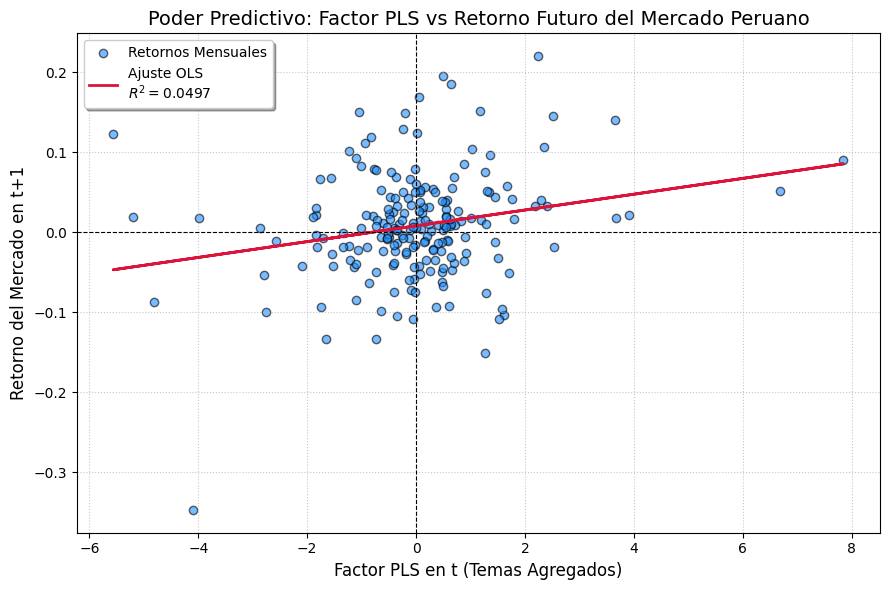

In [ ]:
plt.figure(figsize=(9, 6))

# Gráfico de dispersión
plt.scatter(df_clean['PLS_Factor'], y, alpha=0.6, color='dodgerblue', edgecolor='k', label='Retornos Mensuales')
# Línea de tendencia
const, slope = model_pls.params
plt.plot(df_clean['PLS_Factor'], slope * df_clean['PLS_Factor'] + const, 
         color='crimson', linewidth=2, 
         label=f'Ajuste OLS\n$R^2 = {model_pls.rsquared:.4f}$')

plt.title('Poder Predictivo: Factor PLS vs Retorno Futuro del Mercado Peruano', fontsize=14)
plt.xlabel('Factor PLS en t (Temas Agregados)', fontsize=12)
plt.ylabel('Retorno del Mercado en t+1', fontsize=12)
plt.axhline(0, color='black', linewidth=0.8, linestyle='--')
plt.axvline(0, color='black', linewidth=0.8, linestyle='--')
plt.grid(True, linestyle=':', alpha=0.7)
plt.legend(loc='upper left', frameon=True, shadow=True)
plt.tight_layout()

In [39]:
# Guardar la imagen para tu documento
plt.savefig('data/grafico_predictivo_pls.png', dpi=300)
print("Se ha generado y guardado el gráfico: 'data/grafico_predictivo_pls.png'")

# Guardar la base de datos final
df_clean.to_csv('data/base_predictiva_final.csv', index=False)

Se ha generado y guardado el gráfico: 'data/grafico_predictivo_pls.png'


<Figure size 640x480 with 0 Axes>

### 7. BACKTESTING: ESTRATEGIA DE MARKET TIMING

In [40]:
print("==================================================")
print("SECCIÓN 3: Evaluación Económica (Estrategia PLS)")
print("==================================================")

# 1. Obtener las predicciones del modelo PLS para el mes t+1
df_clean['Prediccion_Mercado'] = model_pls.predict(X_pls)

SECCIÓN 3: Evaluación Económica (Estrategia PLS)


In [41]:
# 2. Regla de inversión (Market Timing):
# Si el modelo predice que el mercado subirá (> 0), invertimos (Posición = 1)
# Si el modelo predice que el mercado bajará (< 0), nos quedamos en efectivo (Posición = 0)
df_clean['Posicion_PLS'] = np.where(df_clean['Prediccion_Mercado'] > 0, 1, 0)

In [42]:
# 3. Calcular los retornos de la estrategia
# El retorno de nuestra estrategia es la posición que tomamos multiplicada por el retorno real que ocurrió
df_clean['Retorno_Estrategia_PLS'] = df_clean['Posicion_PLS'] * df_clean['mkt_ret_lead1']

In [43]:
# 4. Calcular Retornos Acumulados para el gráfico (empezando en 1 o base 100)
df_clean['Acumulado_Mercado'] = (1 + df_clean['mkt_ret_lead1']).cumprod()
df_clean['Acumulado_Estrategia'] = (1 + df_clean['Retorno_Estrategia_PLS']).cumprod()

In [44]:
# 5. Calcular Métricas de Desempeño (Sharpe Ratio Anualizado)
# Asumiendo 12 meses en un año
sharpe_mercado = (df_clean['mkt_ret_lead1'].mean() / df_clean['mkt_ret_lead1'].std()) * np.sqrt(12)
sharpe_estrategia = (df_clean['Retorno_Estrategia_PLS'].mean() / df_clean['Retorno_Estrategia_PLS'].std()) * np.sqrt(12)

print(f"Sharpe Ratio del Mercado (Buy & Hold): {sharpe_mercado:.2f}")
print(f"Sharpe Ratio de la Estrategia PLS: {sharpe_estrategia:.2f}")

Sharpe Ratio del Mercado (Buy & Hold): 0.42
Sharpe Ratio de la Estrategia PLS: 0.59


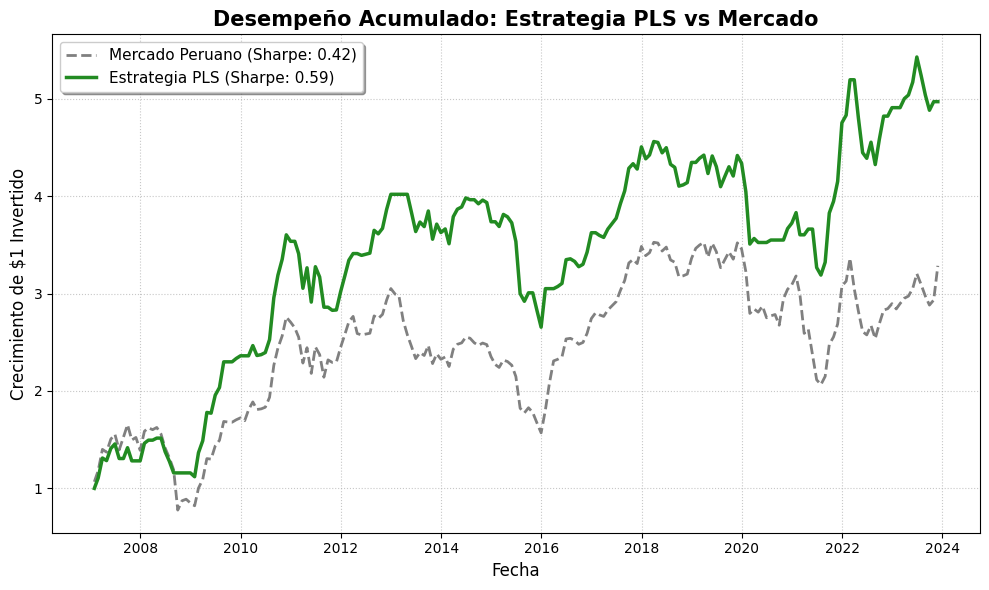

In [45]:
# ==========================================
# 8. GRÁFICO FINAL DE RETORNOS ACUMULADOS
# ==========================================
plt.figure(figsize=(10, 6))

plt.plot(df_clean['date'], df_clean['Acumulado_Mercado'], 
         label=f'Mercado Peruano (Sharpe: {sharpe_mercado:.2f})', 
         color='gray', linewidth=2, linestyle='--')

plt.plot(df_clean['date'], df_clean['Acumulado_Estrategia'], 
         label=f'Estrategia PLS (Sharpe: {sharpe_estrategia:.2f})', 
         color='forestgreen', linewidth=2.5)

plt.title('Desempeño Acumulado: Estrategia PLS vs Mercado', fontsize=15, fontweight='bold')
plt.xlabel('Fecha', fontsize=12)
plt.ylabel('Crecimiento de $1 Invertido', fontsize=12)
plt.legend(loc='upper left', fontsize=11, frameon=True, shadow=True)
plt.grid(True, linestyle=':', alpha=0.7)
plt.tight_layout()

In [46]:
# Guardar la imagen para tu documento
plt.savefig('data/grafico_backtesting_estrategia.png', dpi=300)
print("\nSe ha generado y guardado el gráfico: 'data/grafico_backtesting_estrategia.png'")

# Guardar base con todas las columnas finales
df_clean.to_csv('data/base_completa_con_estrategia.csv', index=False)


Se ha generado y guardado el gráfico: 'data/grafico_backtesting_estrategia.png'


<Figure size 640x480 with 0 Axes>